## Sea level rise analysis for Boston tide gauge

In [1]:
"""
:Project:   boston-tides
:Created:   Tue Oct 19 16:14:49 2021
:Filename:  boston_slr.ipynb

Sea level rise analysis for Boston tide gauge. Fits sea level model to empirical projections from the IPCC Sixth Assessment Report.

Python implementation of sea level analysis from:
    Lempert, R., Sriver, R. L., & Keller, K. (2012). Characterizing Uncertain Sea Level Rise 
    Projections to Support Investment Decisions (No. CEC-500-2012-056). California Energy Commission Sacramento, CA, USA. 

Authors of original R code:
    Klaus Keller <klaus@psu.edu>
    Ryan Sriver <rsriver@illinois.edu>
"""
__version__ = "2.0"
__author__ = "Perry Oddo <perry.oddo@nasa.gov>"

In [1]:
import math
import netCDF4
import pickle
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from matplotlib.lines import Line2D
from scipy import stats
from sklearn.metrics import r2_score 
from statistics import stdev
from statsmodels.tsa.stattools import pacf

random.seed(10)
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

### Data Processing

In [2]:
"""
Download and process sea level data. Combines sea level reconstruction from Talke et al. (2018):
    Talke, S. A., Kemp, A. C., & Woodruff, J. (2018). Relative Sea Level, Tides, 
    and Extreme Water Levels in Boston Harbor From 1825 to 2018. Journal of Geophysical Research: 
    Oceans, 123(6), 3895–3914. https://doi.org/10.1029/2017JC013645

Concatenates with recent data from NOAA Tides and Currents
"""
#from data import get_full_data

In [3]:
# Read in full data frame
df_full = pd.read_csv("data/boston_annual_msl.csv", index_col=0)

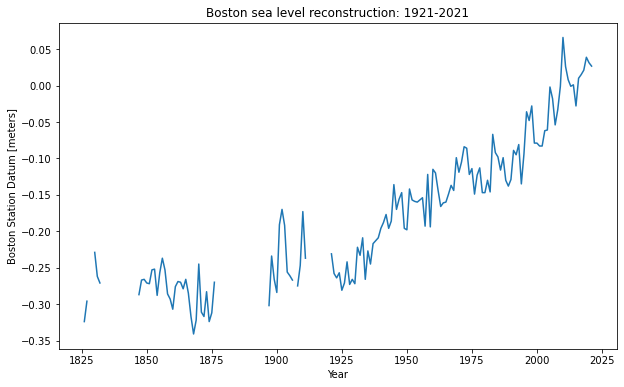

In [4]:
# Plot annual mean sea level
plt.plot(df_full.year, df_full.sea_level, label="Mean sea level")
plt.xlabel("Year")
plt.ylabel("Boston Station Datum [meters]")
plt.title("Boston sea level reconstruction: 1921-2021")
plt.show()

In [5]:
# Re-frame so sea levels are relative to 1995-2014 baseline to align with IPCC AR6
print(df_full.year[-27:-7])

baseline = np.mean(df_full.sea_level[-27:-7])
df_full["base_level"] = df_full.sea_level - baseline

170    1995
171    1996
172    1997
173    1998
174    1999
175    2000
176    2001
177    2002
178    2003
179    2004
180    2005
181    2006
182    2007
183    2008
184    2009
185    2010
186    2011
187    2012
188    2013
189    2014
Name: year, dtype: int64


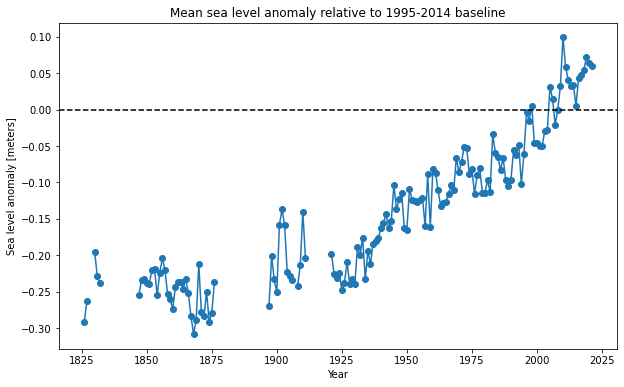

In [14]:
# Plot mean sea level anomalies
plt.plot(df_full.year, df_full.base_level, "-o")
plt.axhline(0, color="black", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Sea level anomaly [meters]")
plt.title("Mean sea level anomaly relative to 1995-2014 baseline")
plt.savefig("plots/slr/1_sea_level_anomaly.png")
plt.show()

### Fitting data and residuals

In [15]:
# Create masked array to only predict on years with finite values
year_full = np.ma.masked_array(df_full.year, np.isnan(df_full.base_level))
msl_full = np.ma.masked_array(df_full.base_level, np.isnan(df_full.base_level))

year = year_full[year_full.mask==False]
msl = msl_full[msl_full.mask==False]

In [16]:
# Fit linear and quadratic trends to annual sea level
lin_fit = np.poly1d(np.polyfit(year, msl, 1))   
quad_fit = np.poly1d(np.polyfit(year, msl, 2))

In [17]:
# Calculate fit
print("Linear R2:", r2_score(msl, lin_fit(year)))
print("Quadratic R2:", r2_score(msl, quad_fit(year)))

Linear R2: 0.8030291537681695
Quadratic R2: 0.9049298789788888


In [18]:
# Select desired fit
best_fit = quad_fit

# Create dictionary for number of parameters
param_dict = {
    "lin_fit" : ["a", "b"],    
    "quad_fit" : ["a", "b", "c"]  
}

param_names = param_dict["quad_fit"]
n_params = len(param_names)

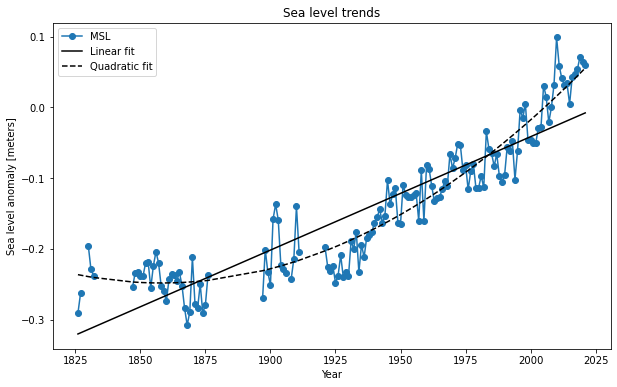

In [19]:
# Plot fitted trends
plt.plot(df_full.year, df_full.base_level, "-o")
plt.plot(year, lin_fit(year), color="black")
plt.plot(year, quad_fit(year), "--",color="black")
plt.xlabel("Year")
plt.ylabel("Sea level anomaly [meters]")
plt.legend(["MSL", "Linear fit", "Quadratic fit"])
plt.title("Sea level trends")
plt.savefig("plots/slr/2_sea_level_trends.png")
plt.show()

In [20]:
# Focus on years with continuous data
assert(np.isfinite(year_full[96:]).all())
df_annual = df_full[df_full["year"] > 1921]

# De-trend record
detrended = df_annual.base_level - best_fit(df_annual.year)

# Find residuals
resids = np.array(detrended)

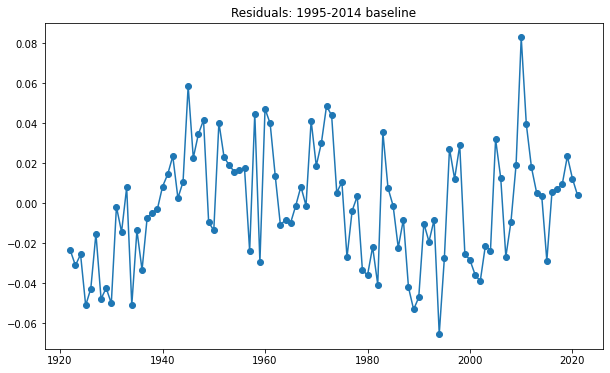

In [21]:
# Plot residuals 
plt.plot(df_annual.year, resids, "-o")
plt.title("Residuals: 1995-2014 baseline")
plt.show()

In [22]:
# Bootstrap residuals
n_samples = 100_000
n_years = len(df_annual.year)

# Initialize empty array for residuals and standard deviations
boot_mat = np.empty([n_samples, n_years])
boot_sd = np.empty(n_samples)
boot_mat.shape

# Resample residuals
for i in range(0, n_samples):
    boot_mat[i,] = random.sample(set(resids), n_years)
    boot_sd[i] = stdev(boot_mat[i,])

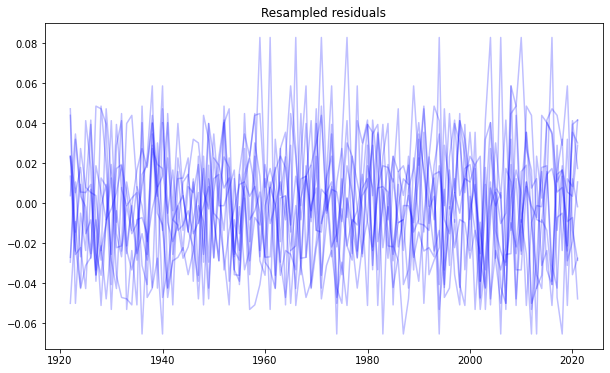

In [23]:
# Plot a few to check
plot_samp = boot_mat[random.sample(range(0, boot_mat.shape[0]), 10)]

plt.plot(df_annual.year, np.transpose(plot_samp), color="blue", alpha=0.25)
plt.title("Resampled residuals")
plt.show()

### Create new residuals from bootstraps with autoregressive structure of original data

In [24]:
# Calculate partial auto-correlation function 
pac = pacf(resids, nlags=5)
print("Partial autocorrelation coefficient:", pac[1])

# Initialize new array and loop through samples/years
boot_mat_ar = np.empty([n_samples, n_years])

for i in range(0, n_samples):
    for j in range(0, n_years):
        boot_mat_ar[i,j] = pac[1] * boot_mat_ar[i, j-1] + np.random.normal(loc=0, scale=boot_sd[i], size=1)

Partial autocorrelation coefficient: 0.48184504073026574


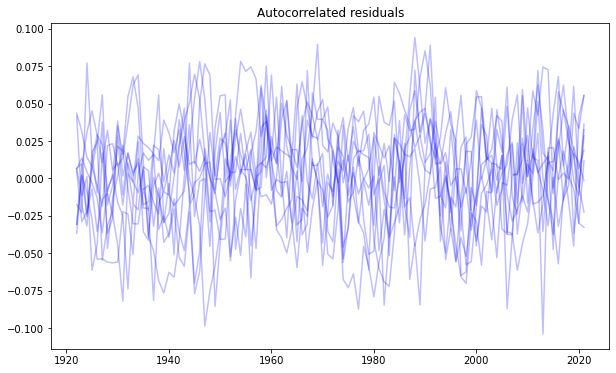

In [25]:
# Plot a few to check
plot_samp = boot_mat_ar[random.sample(range(0, boot_mat_ar.shape[0]), 10)]

plt.plot(df_annual.year, np.transpose(plot_samp), color="blue", alpha=0.25)
plt.title("Autocorrelated residuals")
plt.show()

In [26]:
# Apply new autocorrelated residuals to polynomial fit
boot_slr = np.empty([n_samples, n_years])

for i in range(0, n_samples):
    boot_slr[i,] = df_annual["base_level"] + boot_mat_ar[i,]

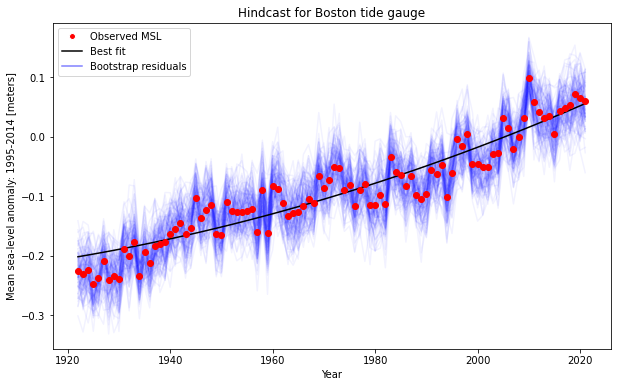

In [27]:
# Plot observed, polynomial fit, and sampling of autocorrelated bootstraps
plot_samp = boot_slr[random.sample(range(0, boot_slr.shape[0]), 100)]

plt.plot(df_annual.year, np.transpose(plot_samp), color="blue", alpha=0.05)
plt.plot(df_annual.year, best_fit(df_annual.year), color="black")
plt.plot(df_annual.year, df_annual.base_level, "o", color="red")
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")
plt.title("Hindcast for Boston tide gauge")

legend_elements = [
    Line2D([0], [0], marker="o", color='w', markerfacecolor="red", label="Observed MSL"),
    Line2D([0],[0], color="black", label="Best fit"),
    Line2D([0], [0], color="blue", alpha=0.5, label="Bootstrap residuals")
]

plt.legend(handles=legend_elements)
plt.savefig("plots/slr/3_autocorrelated_residuals.png")
plt.show()

### Extend trends to 2100

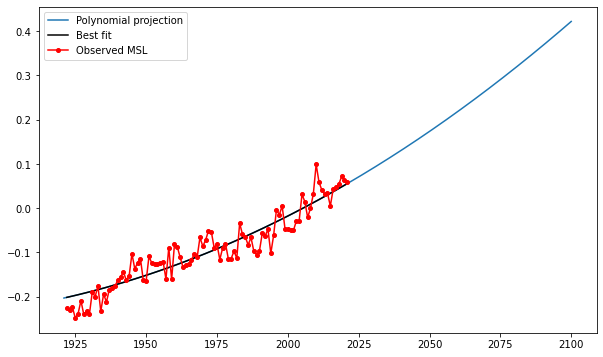

In [90]:
# Define new date range
years_extend = range(2021,2100+1)
years_extra = range(1921,2100+1)
n_extra = len(years_extra)

# Fit new years
predict_global = best_fit(years_extra)

# Plot
plt.plot(years_extra, predict_global, label="Polynomial projection")
plt.plot(df_annual.year, best_fit(df_annual.year), color="black", label="Best fit")
plt.plot(df_annual.year, df_annual.base_level, "-o", color="red", markersize=4, label="Observed MSL")
plt.legend()
plt.show()

In [91]:
# Calculate polynomial coefficients bootstrap projections
boot_fit_coef = np.empty([n_samples, n_params])
boot_fit_predict = np.empty([n_samples, n_extra])

# Loop through samples
for i in range(0, n_samples):

    # Fit each bootstrap
    poly_new = np.poly1d(np.polyfit(df_annual.year, boot_slr[i,], n_params-1))

    # Extract coefficients
    boot_fit_coef[i,0] = poly_new.coefficients[0]
    boot_fit_coef[i,1] = poly_new.coefficients[1]
    boot_fit_coef[i,2] = poly_new.coefficients[2]

    # Create prediction
    boot_fit_predict[i,] = poly_new(years_extra)

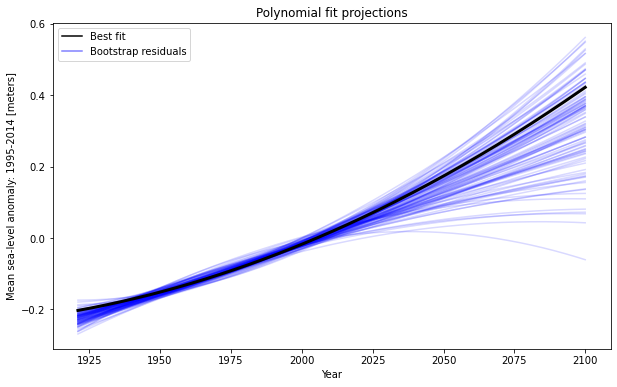

In [92]:
# Plot polynomial projections
plot_samp = boot_fit_predict[random.sample(range(0, boot_fit_predict.shape[0]), 100)]

plt.plot(years_extra, np.transpose(plot_samp), color="blue", alpha=0.15)
plt.plot(years_extra, predict_global, color="black", lw=3)
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")
plt.title("Polynomial fit projections")

legend_elements = [
    Line2D([0], [0], color="black", label="Best fit"),
    Line2D([0], [0], color="blue", alpha=0.5, label="Bootstrap residuals")
]

plt.legend(handles=legend_elements)
plt.show()

### Construct simple model for non-stationary sea level rise

In [93]:
# Model based on Lempert et al. 2012
def slrThreshold(years, slr_base, c_star, t_star):
    """Non-stationary model where the SLR rate, c_star, increases by uncertain amount
    at uncertain time, t_star. Based on implementation from Lempert et al. 2012:
    
    Lempert, R., Sriver, R. L., & Keller, K. (2012). Characterizing Uncertain Sea Level 
        Rise Projections to Support Investment Decisions (No. CEC-500-2012-056). 
        California Energy Commission Sacramento, CA, USA.

    Parameters
    ----------
    years : range
        Years for SLR predictions
    slr_base : array
        Best fit estimations for future SLR
    c_star : float
        Rate increase of SLR (mm/yr)
    t_star : int
        Year of SLR rate increase.

    Returns
    -------
    slr_scenario: array
        Future SLR predictions with uncertain rate increase.
    """
    n_points = len(years)
    slr_scenario = slr_base.copy()
    
    for i in range(0,n_points):
        if years[i] > t_star:
            slr_scenario[i] = slr_base[i] + (years[i]-t_star)*(c_star/1000)
    
    return slr_scenario

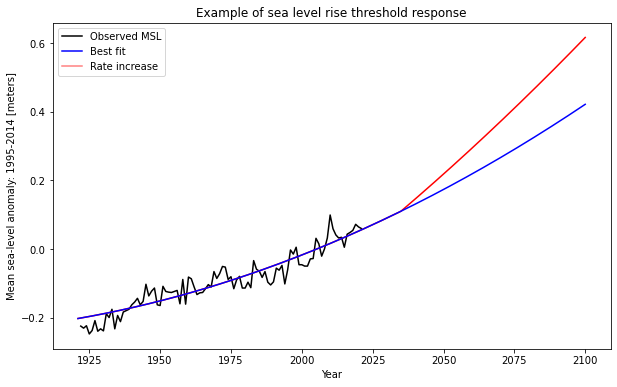

In [94]:
# Plot example showing a rate increase beginning in 2030
predict_global = best_fit(years_extra)
scenario_global = slrThreshold(years_extra, slr_base=predict_global, c_star=3, t_star=2035)

plt.plot(df_annual.year, df_annual.base_level, color="black")
plt.plot(years_extra, scenario_global, color="red")
plt.plot(years_extra, best_fit(years_extra), color="blue")

plt.title("Example of sea level rise threshold response")
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")

legend_elements = [
    Line2D([0], [0], color="black", label="Observed MSL"),
    Line2D([0],[0], color="blue", label="Best fit"),
    Line2D([0], [0], color="red", alpha=0.5, label="Rate increase")
]

plt.legend(handles=legend_elements)
plt.show()

In [95]:
# Product multiple SLR scenarios drawing from prior
c_sample = np.empty([n_samples, 1])
t_star_sample = np.empty([n_samples, 1])
scenario_mc = np.empty([n_samples, n_extra])

c_star_range = [-15, 35]     # Plausible bounds from expert assessment
t_star_range = [2022, 2100]  # Years of possible threshold event

for i in range(0, n_samples):
    c_sample[i] = np.random.uniform(low=c_star_range[0], high=c_star_range[1], size=1)
    t_star_sample[i] = np.random.uniform(low=t_star_range[0], high=t_star_range[1], size=1)
    
    scenario_mc[i,] = slrThreshold(years_extra, boot_fit_predict[i,], c_sample[i], t_star_sample[i])
    
# Define polynomial only projection
scenario_poly_only = scenario_mc.copy()

In [96]:
# Calculate projected residuals
res_boot_proj = np.empty([n_samples, n_extra])

for i in range(0, n_samples):
    for j in range(1, n_extra):
        res_boot_proj[i,j] = pac[1] * res_boot_proj[i,j-1] + np.random.normal(loc=0, scale=boot_sd[i], size=1)

In [97]:
# Superimpose residuals on polynomial fit projections 
for i in range(0):
    scenario_mc[i,] = scenario_mc[i,] + res_boot_proj[i,]

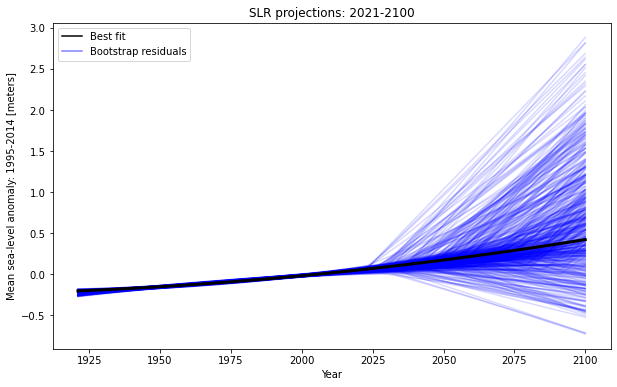

In [98]:
# Plot subset of sea level projections
plot_samp = scenario_mc[random.sample(range(0, scenario_mc.shape[0]), 500)]

plt.plot(years_extra, np.transpose(plot_samp), color="blue", alpha=0.15)
plt.plot(years_extra, predict_global, color="black", lw=3)
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")
plt.title("SLR projections: 2021-2100")

legend_elements = [
    Line2D([0],[0], color="black", label="Best fit"),
    Line2D([0], [0], color="blue", alpha=0.5, label="Bootstrap residuals")
]

plt.legend(handles=legend_elements)
plt.show()

### Rejection sampling to limit projections to IPCC window

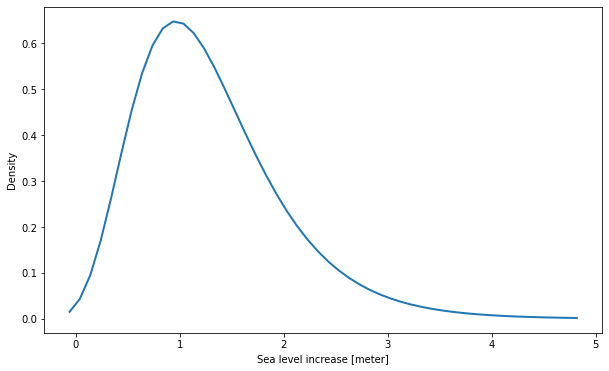

In [99]:
"""
Full set of projections are thinned to correspond to IPCC AR6 projections for sea level in 2100:

    quantile   slr
    --------   ------
    5          0.0623
    17         0.761
    50         1.111
    83         1.665
    95         2.498

Empirical distribution from AR6 SSP5.85 - Low Confidence is approximated by a lognormal distributions with parameters:
    shape=0.34995597818118684
    location=-0.6962996821715732
    scale=1.8700161129358817
    
"""
# Read in best fit parameters for empirical AR6 distribution
with open("outputs/lognorm_params.pkl", "rb") as _:
    lognorm_params = pickle.load(_)

# Read in lower and upper bounds
with open("outputs/slr_bounds_ar6.pkl", "rb") as _:
    lower_b, upper_b = pickle.load(_)

# Number of bins for rejection sampling
n_bin = 50

# Construct probability density function
xs = np.linspace(stats.lognorm.ppf(0.001, lognorm_params[0], lognorm_params[1], lognorm_params[2]),
                 stats.lognorm.ppf(0.999, lognorm_params[0], lognorm_params[1], lognorm_params[2]), n_bin)
rv = stats.lognorm(lognorm_params[0], lognorm_params[1], lognorm_params[2])
xt = xs

# Plot distribution
plt.plot(xs, rv.pdf(xs), lw=2, label='Lognorm fit')
plt.xlabel("Sea level increase [meter]")
plt.ylabel("Density")
plt.show()

In [100]:
# Check that density function integrates to 1
lognorm_pdf = stats.lognorm.pdf(xs, lognorm_params[0], lognorm_params[1], lognorm_params[2])
lognorm_wt_test = lognorm_pdf * (xs[1] - xs[0])
print(np.sum(lognorm_wt_test))

lognorm_wt = lognorm_pdf/np.sum(lognorm_pdf)
print(np.sum(lognorm_wt))

0.9986862323410486
1.0


In [101]:
# Initialize empty data frame for all parameters 
# Add columns for t_star, c_star, slr
n_params_slr = n_params + 3 
params = np.empty([n_samples, n_params_slr])

In [102]:
# Filter outlier projections
scenario_filter = np.empty([n_samples, n_extra])

# Loop through samples
for i in range(0,n_samples):
    if scenario_poly_only[i, n_extra-1] < upper_b and scenario_poly_only[i, n_extra-1] > lower_b:
        params[i,0:n_params] = boot_fit_coef[i,] #4
        params[i,n_params] = t_star_sample[i] #4
        params[i,n_params+1] = c_sample[i] #5
        params[i,n_params+2] = scenario_poly_only[i, n_extra-1] #6
        
        scenario_filter[i,] = scenario_mc[i,]
    
    else:
        params[i,] = np.nan # Set out of bounds entries to nan
        scenario_filter[i,] = np.nan

# Remove nan from projections
filtered = scenario_filter[~np.isnan(scenario_filter).any(axis=1)]
params_array = params[~np.isnan(params).any(axis=1)]

names_out = param_names + ["t_star", "c_star", "slr"]
print(names_out)

# Write parameters to file
params_out = pd.DataFrame(params_array,
                         columns=names_out)
params_out.to_csv("outputs/params_out.csv")

['a', 'b', 'c', 't_star', 'c_star', 'slr']


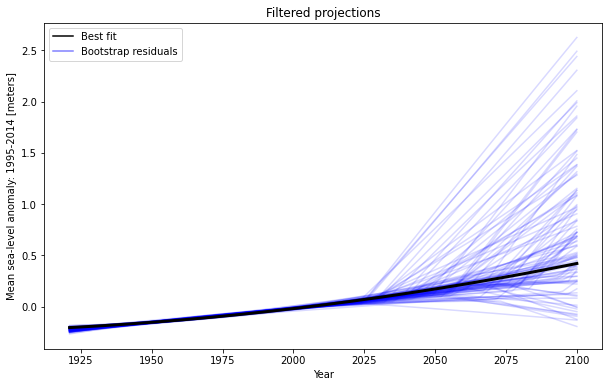

In [103]:
# Plot to check
plot_samp = filtered[random.sample(range(0, filtered.shape[0]), 100)]

plt.plot(years_extra, np.transpose(plot_samp), color="blue", alpha=0.15)
plt.plot(years_extra, predict_global, color="black", lw=3)
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")
plt.title("Filtered projections")

legend_elements = [
    Line2D([0],[0], color="black", label="Best fit"),
    Line2D([0], [0], color="blue", alpha=0.5, label="Bootstrap residuals")
]

plt.legend(handles=legend_elements)
plt.show()

### Thin projections to fit theoretical distribution at 2100

In [104]:
# Read in model output
array = pd.read_csv("outputs/params_out.csv", index_col=[0])

# Insert column for index
array.insert(0, 'index', array.index)
array = array.to_numpy()

# Read through model output and bin values according to target distribution
x_bin=n_bin-1
n_row_array = array.shape[0]
bin_array = np.empty([x_bin, n_row_array, n_params_slr+1])
bin_array[:] = np.NaN

# Loop through each histogram bin
for i in range(0, x_bin):
    
    # Loop through each row
    for j in range(0, n_row_array):
        
        # If SLR projection falls within histogram bounds, extract parameters
        if array[j,n_params_slr] > xt[i] and array[j,n_params_slr] < xt[i+1]:
            
            # Save parameters to bin_array
            for k in range(0, n_params_slr+1):
                bin_array[i,j,k] = array[j,k]

In [105]:
lognorm_dist = []

try:
    for i in range(0, x_bin):
        bin_sub_tmp = bin_array[i,:,:]
        bin_sub_tmp = bin_sub_tmp[~np.isnan(bin_sub_tmp).any(axis=1)]

        sample_size_tmp = lognorm_wt[i] * n_row_array
        sample_size_tmp = int(sample_size_tmp)

        sample_ind_tmp = random.choices(bin_sub_tmp[:,0], k=sample_size_tmp+1)
        sample_ind_tmp = [int(s) for s in sample_ind_tmp]

        lognorm_dist_tmp = np.empty([len(sample_ind_tmp), n_params_slr])

        for j in range(0, len(sample_ind_tmp)):
            for k in range(0,n_params_slr):
                lognorm_dist_tmp[j,k] = array[sample_ind_tmp[j],k+1]

        lognorm_dist.append(lognorm_dist_tmp)
except IndexError:
    gotdata = 'null'
    
# Stack arrays for each bin
lognorm_dist = np.vstack(lognorm_dist)

# Write lognorm distribution parameters to file
params_final = pd.DataFrame(lognorm_dist,
                            columns=names_out)
params_final.to_csv("outputs/params_final.csv")

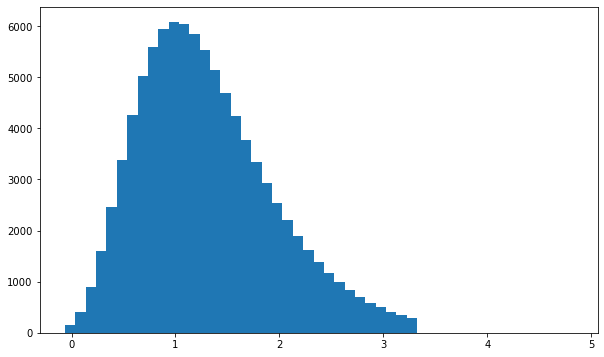

0.9612203678112045
1.0
1.0000000000000002


In [106]:
# Plot thinned distribution
plt.hist(params_final.slr, bins=xt)
plt.show()

# Check that normalized distributions sum to one
d_array = np.histogram(array[:,n_params_slr], bins=xt)
d_lognorm_dist = np.histogram(lognorm_dist[:,n_params_slr-1], bins=xt)

print(np.sum(d_array[0])/len(array[:,n_params_slr]))
print(sum(d_lognorm_dist[0]/len(lognorm_dist[:,n_params_slr-1])))
print(sum(lognorm_wt))

### Plot sea level rise scenarios for rejection sampling parameters

In [107]:
# Initialize empty array
n_constrain = params_final.shape[0]
scenario_constrain = np.empty([n_constrain, n_extra])

# Create polynomial projections from lognorm parameter set
for i in range(0,n_constrain):
    scenario_constrain[i,] = slrThreshold(years_extra, boot_fit_predict[i,], lognorm_dist[i,-2], lognorm_dist[i,-3])
    
scenario_constrain_poly = scenario_constrain

In [108]:
n_constrain = params_final.shape[0]
scenario_constrain = np.empty([n_constrain, n_extra])

In [109]:
# Apply residual structure to polynomial projections
for i in range(0,n_constrain):
    scenario_constrain[i,] = scenario_constrain_poly[i,] + res_boot_proj[i,]

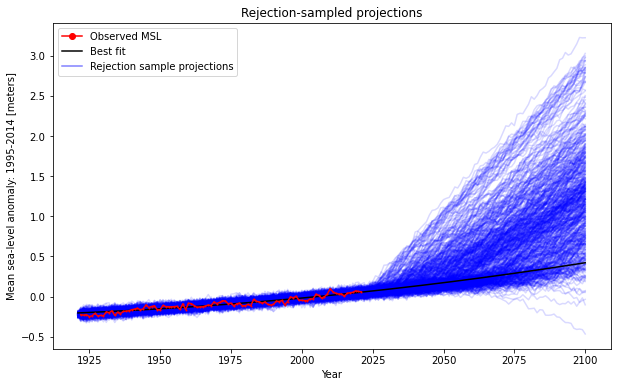

In [110]:
# Plot sampling of final projections
plot_samp = scenario_constrain[random.sample(range(0, scenario_constrain.shape[0]), 500)]

plt.plot(years_extra, np.transpose(plot_samp), color="blue", alpha=0.15, label="Projections")
plt.plot(years_extra, best_fit(years_extra), color="black", label="Best fit")
plt.plot(df_annual.year, df_annual.base_level, "-o", color="red", markersize=1, label="Observations" )
plt.xlabel("Year")
plt.ylabel("Mean sea-level anomaly: 1995-2014 [meters]")
plt.title("Rejection-sampled projections")

legend_elements = [
    Line2D([0], [0], marker="o", color='red', markerfacecolor="red", label="Observed MSL"),
    Line2D([0],[0], color="black", label="Best fit"),
    Line2D([0], [0], color="blue", alpha=0.5, label="Rejection sample projections")
]

plt.legend(handles=legend_elements)
plt.savefig("plots/slr/4_rs_projections.png")
plt.show()

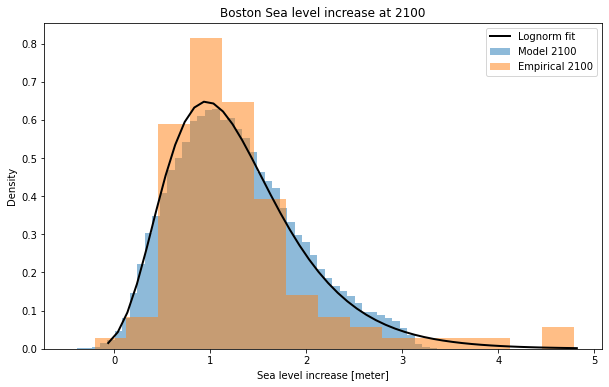

In [111]:
# Plot modeled and empirical distributions
with open("outputs/slr_2100_ar6.pkl", "rb") as _:
    slr_2100_ar6 = pickle.load(_)
    
plt.hist(scenario_constrain[:,-1], density = True, bins=n_bin, label="Model 2100", alpha=0.5)
plt.hist(slr_2100_ar6, density=True, bins=15, label="Empirical 2100", alpha=0.5)
plt.plot(xs, rv.pdf(xs), 'k-', lw=2, label='Lognorm fit')
plt.xlabel("Sea level increase [meter]")
plt.ylabel("Density")
plt.title("Boston Sea level increase at 2100")
plt.legend()
plt.savefig("plots/slr/5_model_distributions.png")
plt.show()

In [112]:
# Compare modeled distribution to lognorm estimate at 2100
slr_2100=scenario_constrain[:,-1]

quantiles=[0.05, 0.17, 0.5, 0.83, 0.95]
empirical=[0.623, 0.761, 1.111, 1.665, 2.498]

for i in range(0, len(quantiles)):
    print("Empirical:", empirical[i], " ", "Model:", round(np.quantile(slr_2100, quantiles[i]),3))

Empirical: 0.623   Model: 0.346
Empirical: 0.761   Model: 0.647
Empirical: 1.111   Model: 1.205
Empirical: 1.665   Model: 1.924
Empirical: 2.498   Model: 2.521


In [126]:
# Save rejection sampling scenarios to file
slr_scenarios = pd.DataFrame(scenario_constrain,
                            columns=list(years_extra),
                            index=range(0, scenario_constrain.shape[0]))

slr_scenarios.to_csv("outputs/slr_scenarios.csv", index=False)